## Creating a mesh and triangulating a surface
### a guided look at what matplotlib.tri does

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import timeit

### Illustration of tri.Triangulation applied to a 2-D square area.  Here we divide the square region into 3 x 3, which yields 3x3x2 triangles

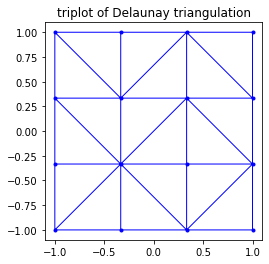

Indices of the triangles, with (0,0) in top left corner
[[ 6 11  7]
 [10 11  6]
 [15 11 14]
 [14 11 10]
 [ 2  7  3]
 [ 2  6  7]
 [ 6  2  5]
 [ 5  2  1]
 [ 5  1  0]
 [ 0  4  5]
 [12 13  9]
 [ 9  8 12]
 [13 14  9]
 [ 9 14 10]
 [10  6  9]
 [ 6  5  9]
 [ 4  8  9]
 [ 9  5  4]]


In [2]:
###### define the x and y axes
N = 4  #the number of defining points on a side.  Will yield 2*(N-1)**2 triangles, each containing 3 pts in 2-D
x = np.linspace(-1,1,N)  # left to right
y = np.linspace(1,-1,N)  # top to bottom  (to get consistency with triplots which start in upper left corner)
X,Y = np.meshgrid(x,y) # meshgrid to simplfy indexing (permits evaluation of function of x, y by simple indexing:  think of
# addressing a 2-d matrix, but meshgrid creates an X vector that, when paired with a Y vector, allows you to address
# any point within the mesh, using a single index to get at both x and y
#print(x,y)
xx = X.flatten()  #unfurl them:  instead of a 2-D array, make them 1-D.  The order is Row 0, Column across, then Row 1, etc
# in a rastered fashion
yy = Y.flatten()
#print(xx)
#print(yy)
tritri = tri.Triangulation(xx,yy)  # submit for triangulation
fig1, ax1 = plt.subplots()  # and plot
ax1.set_aspect('equal')
ax1.triplot(tritri, 'b.-', lw=1) # using special triplot to get the triangles
ax1.set_title('triplot of Delaunay triangulation')
plt.show()

#  Now to get the indices of all the triangles, do this:
triangles = tritri.triangles  # the triangles are indices numbered from top left corner
print("Indices of the triangles, with (0,0) in top left corner")
print(triangles)  # should show numpy arrays of indices.  For a 4x4 array it goes
# 0  1  2  3
# 4  5  6  7
# 8  9  10 11
# 12 13 14 15
# so a row [6 11 7] represents a triangle whose right angle is on the right side of the matrix


# Here's a quick function that expects rows consisting of coordinates (x,y) of the vertices of the triangles
#  Note that triangles are defined in a counter-clockwise direction so c2-c1 cross c3-c1 yields positive area
# 
def get_both(c1,c2,c3):   
    #  assumes c1, c2, c3 all have same dimensions, either 2-D or 3-D
    shape1 = c1.shape[1] #determine the number of columns (dimensions) of c1 (needed later)
    centroids = np.array((c1+c2+c3)/3) # get coordinates of center of triangle
    areas = 0.5*np.cross((c2-c1),(c3-c1))  # get directed area.  Note: if c1, c2, c3 are 
    # 2-D arrays, then np.cross() returns only a single z column vector.  If (c1,c2,c3) are three-dimensional
    # then np.cross() returns a column of x,y,z for each area.  For later calculations, we'd like 
    # areas and centroids to return equal shapes, so we duplicate the areas over two columns:
    #if shape1 == 2:
        #areas = 0.5*np.outer(areas,(1,1)) #this is a simple way to duplicate the columns
                                        # while preserving the area
    return np.array(centroids), np.array(areas)  # return Numpy arrays of centroids and areas


# Now we bolt the x-array and the y-array together using np.vstack(), reshaped to be flat, using Fortran order for
# readability
#   and finally we reshape it to yield ordered rows of coordinates.  Note that reshape() uses -1 on the first index
# which makes Numpy infer the length of the array

### How to turn two 1-D arrays of x and y values into a single 2-D array arranged side-by-side:

In [3]:
a = np.array((0, 1, 2, 3))  # here are two vectors
b = np.array((4, 5, 6, 7))  # that we would like to reshape side-by-side to look like [0 4]
#                                                                                     [1 5] , etc.
print("a = ",a)
print("b = ",b)
c = np.vstack((a,b)).reshape((-1,),order = 'F') #[Note:  the -1 indicates Numpy should infer the length]
print("Fortran order, c = ", c)
# The order parameter is set to 'F' for Fortran, an ordering that puts a and b side-by side
# If we had done "C" ordering (same as Python), we'd get:
cc = np.vstack((a,b)).reshape((-1,),order = 'C')
print("C order, cc = ", c)
print("They look identical, but are not, which we find out when we reshape them to get a vertically stacked column:")
# And now we reshape to give column vectors
d = c.reshape(-1,2)
print("(Fortran):\n",d)
e = cc.reshape(-1,2)
print("(C):\n",e)
print("Clearly, Fortran ordering yields the correct indexing into a, b pairs")

a =  [0 1 2 3]
b =  [4 5 6 7]
Fortran order, c =  [0 4 1 5 2 6 3 7]
C order, cc =  [0 4 1 5 2 6 3 7]
They look identical, but are not, which we find out when we reshape them to get a vertically stacked column:
(Fortran):
 [[0 4]
 [1 5]
 [2 6]
 [3 7]]
(C):
 [[0 1]
 [2 3]
 [4 5]
 [6 7]]
Clearly, Fortran ordering yields the correct indexing into a, b pairs


### So now we have the indices of all the points that represent the 18 triangles.  We want to group them so that we have the coordinates of each of the vertices.  We do this in two steps:  reshape into a column of  x,y pairs, using vstack(), and then divide them into groups of 3:

Here are the coordinates of the first 6 vertices, in order (c1,c2,c3),(c1,c2,c3),...
[[ 0.33333333  0.33333333]
 [ 1.         -0.33333333]
 [ 1.          0.33333333]
 [ 0.33333333 -0.33333333]
 [ 1.         -0.33333333]
 [ 0.33333333  0.33333333]]
After splitting into c1, c2, c3 we get (just the first two):

 c1:
 [[ 0.33333333  0.33333333]
 [ 0.33333333 -0.33333333]] 

 c2:
 [[ 1.         -0.33333333]
 [ 1.         -0.33333333]] 

 c3:
 [[1.         0.33333333]
 [0.33333333 0.33333333]] 


And here we mark the centroids of all the triangles
And check that the total area is 4: 4.0


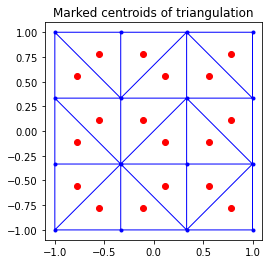

In [6]:
tri_vertices = np.vstack((xx[triangles.flatten()],yy[triangles.flatten()])).reshape((-1,),order='F').reshape(6*(N-1)**2,2)
# Note that in reshaping we could equally well have referred to one of axes as "-1", which makes Numpy figure it out,
# instead of explicitwriting 6*(N-1)**2 
tri_vertices = np.vstack((xx[triangles.flatten()],yy[triangles.flatten()])).reshape((-1,),order='F').reshape(-1,2)


print("Here are the coordinates of the first 6 vertices, in order (c1,c2,c3),(c1,c2,c3),...")
print(tri_vertices[0:6])
# Now put split them into the usual sets of 3 to match what get_both() expects, the values 
# of the coordinates of the three vertices of each triangle
# You'll see that there are 18 of these, corresponding to the 18 triangles resulting from the 4x4 grid
c1 = tri_vertices[0::3]  # 0,3,6... are c1
c2 = tri_vertices[1::3]  # 1,4,7... are c2
c3 = tri_vertices[2::3]  # 2,5,8... are c3
print("After splitting into c1, c2, c3 we get (just the first two):\n")
centroids, areas = get_both(c1,c2,c3)  # Get centroids and areas of triangles

print(" c1:\n",c1[0:2,],"\n\n","c2:\n",c2[0:2,],"\n\n","c3:\n",c3[0:2,],"\n\n")
fig2, ax2 = plt.subplots()  #and plot
ax2.set_aspect('equal')
ax2.triplot(tritri, 'b.-', lw=1)
print("And here we mark the centroids of all the triangles")
ax2.set_title('Marked centroids of triangulation')
ax2.plot(centroids[:,0],centroids[:,1],'ro')  #plot the (x,y) pairs of centroids as red dots
#  Now check that the areas are positive and that they add up to the expected result
print("And check that the total area is 4:", np.sum(areas))

### But enough 2-D.  2-D is simplified in the sense that the cross product yields a vector in the 3rd (z) dimension, out of the x-y plane.  So the cross product only returns a single-column array.  In 3-D, the cross product returns 3 components, because in general the triangle does not lie in the x-y plane.

Starting the timer for the Pythonic calculation...

Pythonic calculation elapsed time:  0.005669099999977334 seconds

Not yet a 3-D plot, but this shows how the triangles look on a rectangular grid:
Total area:  12.254438756408156
Expected surface area of sphere:  12.566370614359172
Fractional error in total area:  -0.024822748550371598


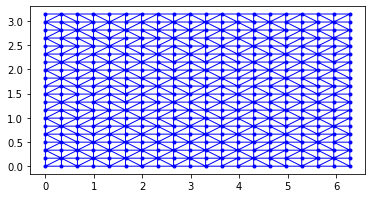

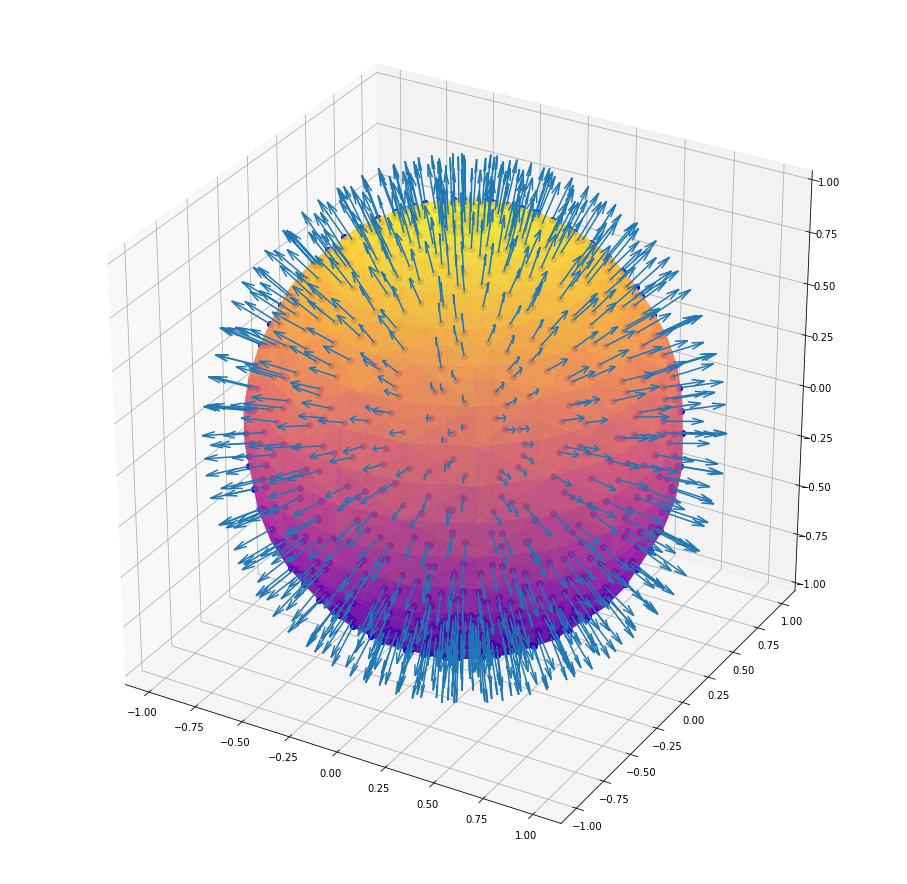

In [11]:
def get_both3D(c1,c2,c3):   
    #  assumes c1, c2, c3 all have same dimensions, either 2-D or 3-D
    shape = c1.shape[1] #determine the number of columns of c1
    #print(" dim ",dim, "shape ", c1.shape[1])
    centroids = np.array((c1+c2+c3)/3) # get coordinates of center of triangle
    areas = 0.5*np.cross((c2-c1),(c3-c1))  # get directed area.  Note: if c1, c2, c3 are 
    # 2-D arrays, then np.cross() returns only a single z column vector.  If (c1,c2,c3) are three-dimensional
    # then np.cross() returns a column of x,y,z for each area.  For later calculations, we'd like 
    # areas and centroids to return equal shapes, so we duplicate the areas over two columns:
    if shape == 3:
        #areas = np.outer(areas,(1,1,1)) #this is a simple way to duplicate the columns
                                        # while preserving the area
        areas_reversed = np.where ((areas*centroids).sum(axis=1) < 0,-1,1) # mark where the area points inward toward the origin
# We need to reverse the area if the dot product is negative.  
# Note that area_reversed yields a single value for each of the N triangles.  We need to extend it to a 3 x N, so that
# we reverse all x,y,z indices for that triangle

# Multiply by areas_reversed by on all 3 indices
        areas = areas*(np.outer(areas_reversed,(1,1,1)))
    return np.array(centroids), np.array(areas)  # return Numpy arrays of centroids and areas

print("Starting the timer for the Pythonic calculation...\n")
starttime = timeit.default_timer()
res = 20
r = 1.0
u = np.linspace(0, 2.0 * np.pi, res)  #phi coordinate
v = np.linspace( 0,np.pi,res)        #theta coordinate
#print(u)
#print(v)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()  #required to do triangulation

# Triangulate parameter space to determine the triangles
tritri = tri.Triangulation(u, v)
triangles=tritri.triangles  #set of indices of each of the triangles
x = r * np.sin(v) * np.cos(u)
y = r * np.sin(v) * np.sin(u)
z = r * np.cos(v)

tri_vertices = np.vstack((x[triangles.flatten()],y[triangles.flatten()],z[triangles.flatten()])).reshape((-1,),order='F').reshape(6*(res-1)**2,3)
#ax3.plot(arr2[0,0],arr2[0,1],'ko')
c1 = tri_vertices[0::3]  # 0,3,6... are c1
c2 = tri_vertices[1::3]  # 1,4,7... are c2
c3 = tri_vertices[2::3]  # 2,5,8... are c3
#print("coordinates")
# print(c1)
# print(c2)
# print(c3)

centroids, areas = get_both3D(c1,c2,c3)  # Get centroids and areas of triangles

# In 2-D it is simple to see which way (along the z-axis) the directed areas lie.  But in 3-D, some of the triangles
# will have been traversed in the wrong order, because they are pasted on to the back side of the 3-D object.
# We need to test to see if any areas point the wrong way.  If so, reverse all coordinates in that area

#area_reversed = np.where ((areas*centroids).sum(axis=1) < 0,-1,1) # mark where the area points inward toward the origin
# We need to reverse the area if the dot product is negative.  
# Note that area_reversed yields a single value for each of the N triangles.  We need to extend it to a 3 x N, so that
# we reverse all x,y,z indices for that triangle

# For Multiply area by -1 on all 3 indices
#areas_outward = areas*(np.outer(vec,(1,1,1)))

elapsed_time =  timeit.default_timer() - starttime
print("Pythonic calculation elapsed time: ",elapsed_time , "seconds\n")



print("Not yet a 3-D plot, but this shows how the triangles look on a rectangular grid:")
fig3, ax3 = plt.subplots()  #and plot
ax3.set_aspect('equal')
ax3.triplot(tritri, 'b.-', lw=1)  #plot triangles on a rectangular grid

# here for 3d plotting


fig = plt.figure(figsize=plt.figaspect(1)*4)  # Square figure
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, triangles=tritri.triangles,
                        alpha=.7, cmap="plasma")
triangles = tritri.triangles
ax.quiver(centroids[:,0],centroids[:,1],centroids[:,2],areas[:,0],areas[:,1],areas[:,2],length = 0.2,normalize=True)

# a = x[triangles].sum(axis=1)/3.0  #x coordinates of centroids
# print(a)
# b = y[triangles].sum(axis=1)/3.0  #y coordinates of centroids
# c = z[triangles].sum(axis=1)/3.0  #z

# d = np.vstack((a,b,c)).reshape((-1,),order='F').reshape(-1,3) #reshape into x,y pairs (use 3 for 3D)



# To get the total (directed) area of all of the triangles
# we multiply the centroids (which should have unit length)
# by the directed areas, and sum over all rows
# (If we didn't do this, we'd get a sum of 0 because half the directed areas are in the negative half-plane)
total_area = (areas*centroids).sum()
print("Total area: ", total_area)
area_limit = 4*np.pi
print("Expected surface area of sphere: ", area_limit)
print("Fractional error in total area: ",(total_area-area_limit)/area_limit)

ax.plot3D(centroids[:,0],centroids[:,1],centroids[:,2],'bo')


In [6]:
# Lifted from the web, here's a standard triangulation example
#https://matplotlib.org/stable/gallery/images_contours_and_fields/triplot_demo.html

# First create the x and y coordinates of the points.
n_angles = 36 #was 36
n_radii = 8 # was 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
#print(angles)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
#print(angles)
angles[:, 1::2] += np.pi / n_angles
#print(angles)

x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()
#print("\n\n",x)
#print("\n\n", y)
# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

Text(0.5, 1.0, 'triplot of Delaunay triangulation')

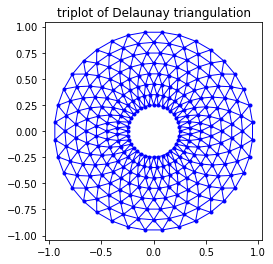

In [7]:
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'b.-', lw=1)
ax1.set_title('triplot of Delaunay triangulation')